0    14985
1    13634
Name: is_sarcastic, dtype: int64
Number of NA values in dataset:  0
Number of NULL values in dataset:  0


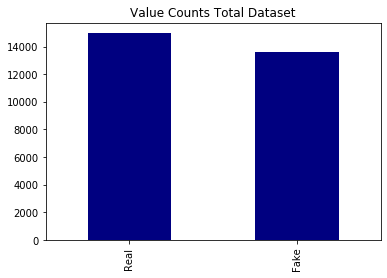

In [319]:
#Section 1: Pre-Processing * 
import pandas as pd
import numpy as np
import os
import seaborn as sns
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

nltk.download('punkt')
os.chdir ("/home/liam/Dropbox/DCU/ML/Assignment/")
df = pd.read_json ("fake_news.json", lines = True)
df = df.drop(columns =['article_link']) ##un-necessary column discarded to aid computation
df["is_sarcastic"] = df["is_sarcastic"].astype("category") ##column was not encoded as a categorical variable
df = df.drop(df.index[7302]) #extreme outlier detected in Section 2.1 
#df.drop_duplicates(subset = 'headline',keep = False, inplace = True) #code to remove duplicate headlines to repeat analysis

#Check for missing values
nas =df['headline'].isna().sum()
nuls = df['headline'].isnull().sum()
print("Number of NA values in dataset: ", nas)
print ("Number of NULL values in dataset: ", nuls)

##Figure 1. Basic value count
pd.value_counts(df['is_sarcastic'])
print(counts) ##note 0 = real news, 1 = fake news

#Figure 1
xticks =("Real", "Fake")
ax =pd.value_counts(df['is_sarcastic']).plot(kind ='bar',title='Value Counts Total Dataset', colormap = 'jet') 
ax.set_xticklabels(xticks)
plt.show()

In [826]:
#Section 1.2: Train, Test & Validation Split * Note Seed = 1
from sklearn.model_selection import train_test_split
X = df['headline']
Y = df['is_sarcastic']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1, stratify = Y) #Stratify used to ensure correct split
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.1,
                                                    shuffle=True,

                                                  random_state=1, stratify = y_train)


#Figures quoted in report and confirmation of class balance in each split
print('Val Set Size: ',len(X_val))
print('Test Set Size: ' ,len(X_test))
print('Train Set Size: ',len(X_train))
print(y_val.value_counts())
print(y_test.value_counts())
print(y_train.value_counts())

#trdf = pd.concat([X_train, y_train], axis=1)
#trdf['headline'] = trdf['headline'].apply(word_tokenize)
#trdf = trdf.drop(trdf.index[[outliers]])
#ts_df = pd.concat([X_test, y_test], axis=1)


Val Set Size:  2147
Test Set Size:  7155
Train Set Size:  19316
0    1124
1    1023
Name: is_sarcastic, dtype: int64
0    3747
1    3408
Name: is_sarcastic, dtype: int64
0    10114
1     9202
Name: is_sarcastic, dtype: int64


In [824]:
#Section 1.3: Finding Duplicates, 
#This was intended to be used to back-inform DF filtering in Section 1 but was not implemented
#due to time constraints

df_real = df[df["is_sarcastic"] == 0]
df_fake = df[df["is_sarcastic"] == 1]

#print(pd.value_counts(df['headline']).nlargest(10)
print(pd.value_counts(df_real['headline']).nlargest(5))
print(pd.value_counts(df_fake['headline']).nlargest(5))

#print(len(df))
real_pre = len(df_real)
fake_pre = len(df_fake)

print('Real Set Length Pre-duplicate Removal:',real_pre)
print('Fake set Length Pre-duplicate Removal:',fake_pre)

df_real.drop_duplicates(subset = 'headline',keep = False, inplace = True) #remove duplicate headlines
df_fake.drop_duplicates(subset = 'headline',keep = False, inplace = True) #remove duplicate headlines

real_post = len(df_real)
fake_post = len(df_fake)
print('Real Set Length Post-duplicate Removal:',real_post)
print('Fake set Length Post-duplicate Removal:',fake_post)


sunday roundup                                                             10
the 20 funniest tweets from women this week                                10
the funniest tweets from parents this week                                  6
the funniest tweets from women this week                                    4
funniest parenting tweets: what moms and dads said on twitter this week     2
Name: headline, dtype: int64
'no way to prevent this,' says only nation where this regularly happens    12
report: make it stop                                                        4
nation not sure how many ex-trump staffers it can safely reabsorb           3
sole remaining lung filled with rich, satisfying flavor                     3
water pistol fired using sideways gangsta grip                              2
Name: headline, dtype: int64
Real Set Length Pre-duplicate Removal: 14985
Fake set Length Pre-duplicate Removal: 13633
Real Set Length Post-duplicate Removal: 14939
Fake set Length Post-dupli

/home/liam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/liam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [820]:
print('num_real_duplicates =', (real_pre - real_post))
print('num_fake_duplicates =', (fake_pre - fake_post))


num_real_duplicates = 46
num_fake_duplicates = 150


Average Train Set word count Real news:  10.713313313313312
Average Train Set word count Fake news:  10.84714683878539


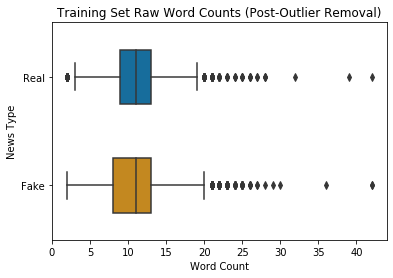

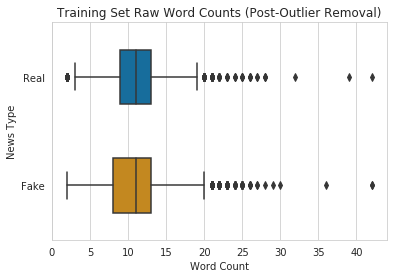

Average Train Set word count Real news:  10.713313313313312
Average Train Set word count Fake news:  10.835766155651728
Standard Deviation Train Set word count Real news:  3.301028585555671
Standard Deviation Train Set word count Fake news:  3.972299009848262


In [838]:
#Section 2.1

#Due to limitations on copying dataframes in the newest version of Pandas;
#major difficulties were encountered when attempting to process the dataframe itself and
#copies/subsets were needed to investigate frequent words etc without compromising compatability
#with downstream sklearn functions.


##df['headline'] = df['headline'].apply(word_tokenize)
#df_real = df[df["is_sarcastic"] == 0]
#df_fake = df[df["is_sarcastic"] == 1]

##Code for identifying index of outlier and removing it; this was used to back-inform processing
# in Section 1.1

#xfake =(trdf['headline'].apply(len))
#print(xfake.idxmax())# find index of outlier
#print(xfake[7302]) #investigate the headline
#outliers = (7302)
#trdf = trdf.drop(trdf.index[outliers])


#careful here that you tokenize first if re-running

#Boxplot of wordcounts after outlier removal
bplot = sns.boxplot(y=trdf['is_sarcastic'], x =(trdf['headline'].apply(len)),

                data=trdf, 
                 width=0.5,
                 palette="colorblind")
xticks =("Real", "Fake")

plt.xlabel("Word Count")
plt.ylabel("News Type")
plt.title("Training Set Raw Word Counts (Post-Outlier Removal)")
#plt.title("Boxplot of Word Counts (Raw Emails)")
bplot.set_yticklabels(xticks)
plt.show(bplot)
         
##Boxplot of raw data showed a clear outlier in the Fake news dataset
##which was investigated
print("Average Train Set word count Real news: ", np.mean(df_real['headline'].apply(len)) )
print ("Average Train Set word count Fake news: ",np.mean(df_fake['headline'].apply(len)) )
print("Standard Deviation Train Set word count Real news: ", np.std(df_real['headline'].apply(len)) )
print ("Standard Deviation Train Set word count Fake news: ",np.std(df_fake['headline'].apply(len)) )


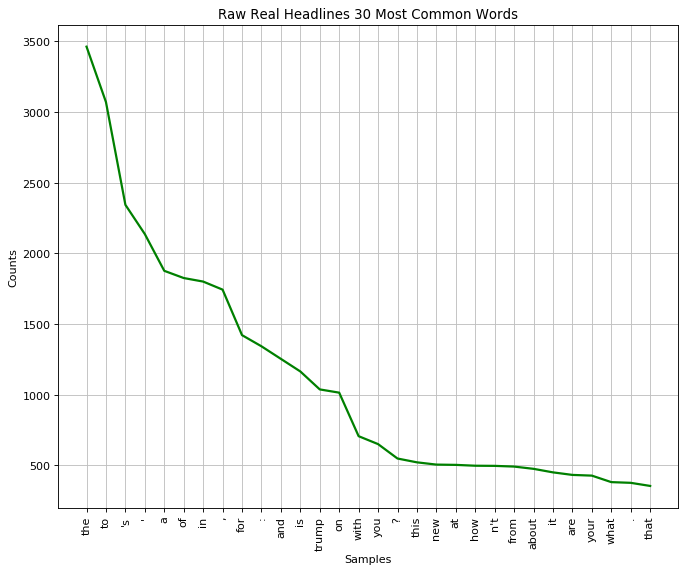

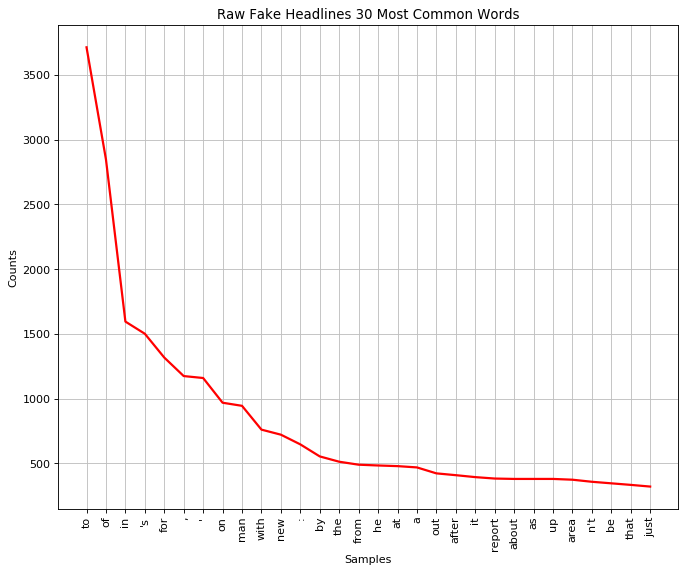

In [152]:
#Section 2.1 Note: NLTK's FreqDist objects proved cumbersome to work with and separate dataframes for each 
#class were created. Certain functions required pre-tokenized headlines while others namely 'FreqDist'required an 
#untokenized dataframe as input and tokenization was carried out inside the function with the suffix '.map(word_tokenize),[])'

from nltk.probability import FreqDist
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords

train_df_real = trdf[trdf["is_sarcastic"] == 0]
train_df_fake = trdf[trdf["is_sarcastic"] == 1]
real_freq = FreqDist(sum(train_df_real['headline'].map(word_tokenize), []))
fake_freq = FreqDist(sum(train_df_fake['headline'].map(word_tokenize),[]))



%matplotlib inline
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.title("Raw Real Headlines 30 Most Common Words")
real_freq.plot(30,cumulative=False, color = 'g')
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.title("Raw Fake Headlines 30 Most Common Words")
fake_freq.plot(30,cumulative=False, color = 'r')


In [183]:
newStopWords = []
def headline_processor(word_list):
        no_punc_word_list = []
        no_stopword_list = []
        for word in word_list:
            if word.isalpha():
                no_punc_word_list.append(word) #remove non-alphanumeric elements
        for word in no_punc_word_list:
           #word = word.lower() #dataset already appears to be in lowercase
           if word not in (stopwords.words("english")+ newStopWords):
               no_stopword_list.append(word)         
        return no_stopword_list

#Need to make copies of the df before you can tokenize/process otherwise original df will be modified
swr_copy_real = train_df_real.copy()
swr_copy_fake = train_df_fake.copy()
print(swr_copy_real)
print(train_df_real)

#swr_copy_real_sub = swr_copy_real.copy()
#swr_copy_real_sub = swr_copy_real_sub.iloc[0:100]
#swr_copy_real_sub['headline'] = swr_copy_real_sub['headline'].map(word_tokenize)
#swr_copy_real_sub['headline'] = swr_copy_real_sub['headline'].apply(email_processor) 
print(swr_copy_real_sub)
#swr_copy_real_sub_fd = swr_copy_real_sub.copy()
#real_freq_swr = FreqDist((swr_copy_real_sub_fd['headline']))

#fake_freq = FreqDist(sum(train_df_fake['headline'].map(word_tokenize),[]))


                                                headline is_sarcastic
1072   the future of video: vertical and growing: mar...            0
12531  turkey clamps down on mine disaster protests a...            0
27757  russians who hacked dnc reportedly target fran...            0
26478                    understanding the islamic state            0
13401  little girl who couldn't believe obama was lea...            0
...                                                  ...          ...
20442  my beautiful reward and the 7 lessons it has t...            0
677    11 life lessons i learned from my year of running            0
2635   rnc proclaims mike pence the winner more than ...            0
8523   playing an aspiring rapper in 'patti cake$,' d...            0
8269   this is what's delaying 'big bang theory' seas...            0

[11239 rows x 2 columns]
                                                headline is_sarcastic
1072   the future of video: vertical and growing: mar...        

In [845]:
# Table 1: Frequency Tables Referenced in Report. Uncomment & rerun for fake news
pd.DataFrame(real_freq_swr.most_common(25))
#pd.DataFrame(fake_freq_swr.most_common(25))

,0,1
0,donald,338
1,says,268
2,women,230
3,world,172
4,make,169
5,gop,157
6,could,155
7,watch,143
8,clinton,141
9,black,140


Number of NA values in dataset before tokenize:  0


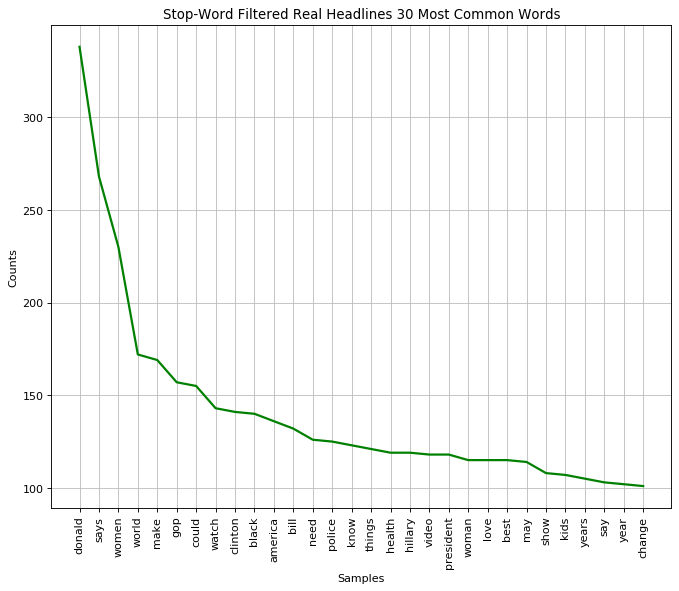

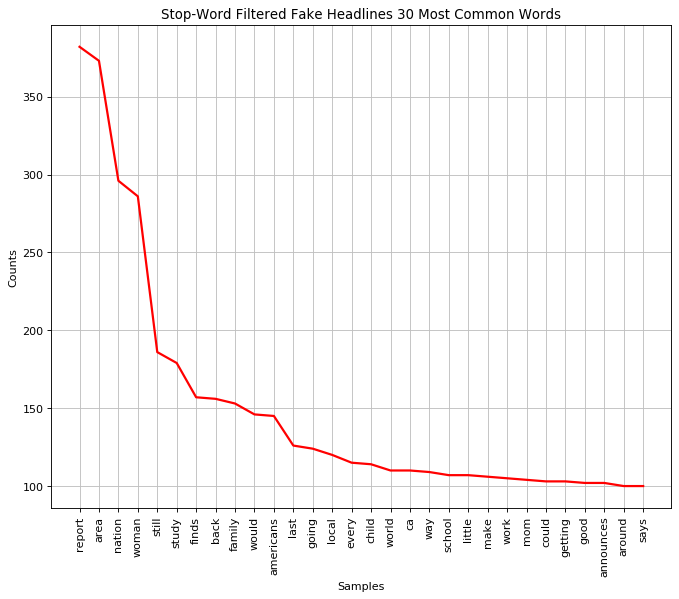

In [284]:
#Two functions were developed to prepare the data for the FreqDist function
#converts the df to a long list; might not work for TF-IDF though


def freq_dist_enabler(tokenized_data_frame):
    allWords = []
    for wordList in tokenized_data_frame:
        allWords += wordList
    return(allWords)
def headline_processor(word_list):
        no_punc_word_list = []
        no_stopword_list = []
        for word in word_list:
            if word.isalpha():
                no_punc_word_list.append(word) #remove non-alphanumeric elements
        for word in no_punc_word_list:
            if word not in (stopwords.words("english")+ shared_words): #additional commmon words
                no_stopword_list.append(word)         
        return no_stopword_list

swr_copy_real = train_df_real.copy() #necessary to avoid over-writing dataframe in memory
swr_copy_fake = train_df_fake.copy()

nas =swr_copy_real['headline'].isna().sum()
print("Number of NA values in dataset before tokenize: ", nas)
swr_copy_real['headline'] = swr_copy_real['headline'].map(word_tokenize)
swr_copy_fake['headline'] = swr_copy_fake['headline'].map(word_tokenize)

#should be able to combine this into a function
stopWords = set(stopwords.words('english') + shared_words)
real_filtered = []
words = freq_dist_enabler(swr_copy_real['headline'])
words = headline_processor(words)
for w in words:
    if w not in stopWords:
        real_filtered.append(w)
real_filtered   
fake_filtered = []
words = freq_dist_enabler(swr_copy_fake['headline'])
words = email_processor(words)
for w in words:
    if w not in stopWords:
        fake_filtered.append(w)
        
#fake_filtered          
## swr_copy_real['headline'] = swr_copy_real_sub['headline'].apply(email_processor) 

real_freq_swr = FreqDist(real_filtered)
fake_freq_swr = FreqDist(fake_filtered)
#real_freq_swr = FreqDist(freq_dist_enabler((swr_copy_real['headline'])))
#fake_freq_swr = FreqDist(freq_dist_enabler((swr_copy_fake['headline'])))

%matplotlib inline
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.title("Stop-Word & Shared Filtered Real Headlines 30 Most Common Words")
real_freq_swr.plot(30,cumulative=False, color = 'g')
plt.show
#plt.subplot(1, 2, 2) 
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.title("Stop-Word & Shared Filtered Fake Headlines 30 Most Common Words")
fake_freq_swr.plot(30,cumulative=False, color = 'r')



In [280]:
#Shared Words after stop-word removal

print("Real:")
real20 = pd.DataFrame(real_freq_swr.most_common(30))
fake20 = pd.DataFrame(fake_freq_swr.most_common(30))

#print(real_freq_swr.tabulate())
#print(fake20[i][0])
#sub_df.iloc[0]['A']
#real20[0]
shared_words = list(set(real20[0]) & set(fake20[0]))  
print("Shared: ", shared_words)
len(shared_words)

Real:
Shared:  ['man', 'time', 'get', 'people', 'day', 'like', 'trump', 'house', 'life', 'one', 'obama', 'white', 'first', 'new']


14

In [850]:
#Shared words after removing entries that were present in the initial 'Top 30' for each set
print("Real:")
real20 = pd.DataFrame(real_freq_swr.most_common(30))
fake20 = pd.DataFrame(fake_freq_swr.most_common(30))

#print(real_freq_swr.tabulate()) #extensive table
#print(fake20[i][0])
#sub_df.iloc[0]['A']
#real20[0]
shared_words = list(set(real20[0]) & set(fake20[0]))  
print("Shared: ", shared_words)
len(shared_words)

Real:
Shared:  ['could', 'says', 'make', 'woman', 'world']


5

In [325]:
#the object you do the freqdist on might have to be separate from the rest of analysis
words = swr_copy_real_sub['headline']

#fake_words = swr_copy_fake_sub
def freq_dist_enabler(words):
    allWords = []
    for wordList in words:
        #print(wordList)
        allWords += wordList
    return(allWords)
words = swr_copy_real['headline']
#words
#words = freq_dist_enabler(words)
#words

#swr_copy_real = train_df_real.copy()
#swr_copy_fake = train_df_fake.copy()    
    
#sub_fd = FreqDist(allWords)
#sub_fd2 = FreqDist(freq_dist_enabler(words))
sub_fd2 = FreqDist(freq_dist_enabler(swr_copy_real_sub['headline']))

#sub_fd2.plot(30,cumulative=False)
#plt.show()

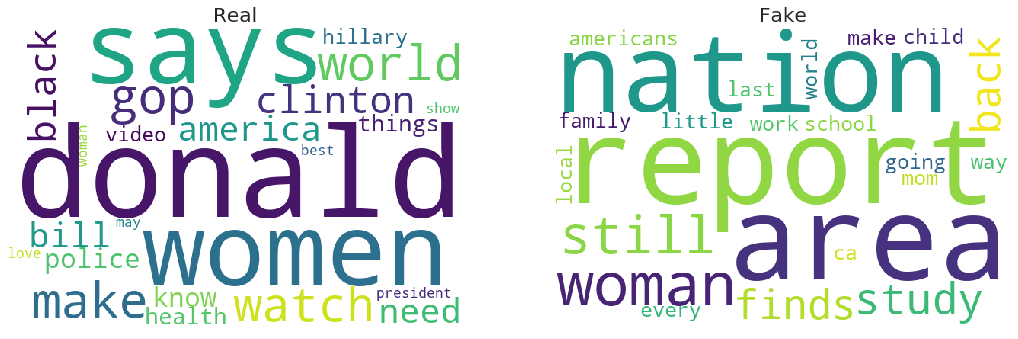

In [847]:
# Supplementary Material for Section 2

#conda install -c https://conda.anaconda.org/conda-forge wordcloud if needed to install
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wordcloud_real =pd.DataFrame(real_freq_swr.most_common(25))
wordcloud_fake = pd.DataFrame(fake_freq_swr.most_common(25))
wordcloud_real = wordcloud_real[0]
wordcloud_fake = wordcloud_fake[0]
real_words_str = ' '.join(wordcloud_real)
fake_words_str = ' '.join(wordcloud_fake)
real_word_cloud = WordCloud(width = 600, height = 400, background_color = 'white').generate(real_words_str)
fake_word_cloud = WordCloud(width = 600, height = 400, background_color = 'white').generate(fake_words_str)

fig, (ax, ax2) = plt.subplots(1,2, figsize = (18,8))
ax.imshow(real_word_cloud)
ax.axis('off')
ax.set_title('Real', fontsize = 20)
ax2.imshow(fake_word_cloud)
ax2.axis('off')
ax2.set_title('Fake', fontsize = 20)
plt.show()


In [427]:
#Section 3.1.Sidenote:
#The effect of stop word removal on the size of the Bag of Words was investigated and while seemingly large; the larger
#version did not present any problem for CPU computation
Xs_bow_raw


<19316x22157 sparse matrix of type '<class 'numpy.int64'>'
	with 190409 stored elements in Compressed Sparse Row format>

In [428]:
Xs_bow_com

<19316x21868 sparse matrix of type '<class 'numpy.int64'>'
	with 127235 stored elements in Compressed Sparse Row format>

In [471]:
#Section 3.1. 
from sklearn.feature_extraction.text import CountVectorizer #AKA BagOfWords
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 

stop_words = text.ENGLISH_STOP_WORDS.union(shared_common_words)
shared_common_words = ['man', 'time', 'get', 'people', 'day', 'like', 'trump', 'house', 'life', 'one', 'obama', 'white', 'first', 'new']

#Significant problems were encountered with Value Errors for the transform & predict functions and a stream-lined 
#function approach could not be developed

#Raw
count_vec = CountVectorizer(ngram_range = (1,1), stop_words=None) #Specify the uni/bi/tri gram etc and the stop-words to be removed
Xs_bow_raw = count_vec.fit_transform(X_train)
X_val_raw = count_vec.transform(X_val) ##This is what the training set has to be processed with
clf_bow = MultinomialNB().fit(Xs_bow_raw, y_train)
vpredicted_bow_raw= clf_bow.predict(X_val_raw)
tpredicted_bow_raw= clf_bow.predict(Xs_bow_raw)
print("BoW MultinomialNB Validation Accuracy Raw Data:",metrics.accuracy_score(y_val, vpredicted_bow_raw)) #combo
print("BoW MultinomialNB Training Accuracy Raw Data:",metrics.accuracy_score(y_train, tpredicted_bow_raw)) #combo


#Standard English Stop-Words removed
count_vec = CountVectorizer(ngram_range = (1,1), stop_words='english') #explain these parameters
Xs_bow_eng = count_vec.fit_transform(X_train)
X_val_eng = count_vec.transform(X_val)
clf_bow = MultinomialNB().fit(Xs_bow_eng, y_train)
vpredicted_bow_eng= clf_bow.predict(X_val_eng)
tpredicted_bow_eng= clf_bow.predict(Xs_bow_eng)
print("BoW MultinomialNB Validation Accuracy with English stop-words removed:",metrics.accuracy_score(y_val, vpredicted_bow_eng)) #combo
print("BoW MultinomialNB Training Accuracy with English stop-words removed:",metrics.accuracy_score(y_train, tpredicted_bow_eng)) #combo

#Shared Common Words & StopWords
count_vec = CountVectorizer(ngram_range = (1,1), stop_words=stop_words) #explain these parameters
Xs_bow_com = count_vec.fit_transform(X_train)
X_val_com = count_vec.transform(X_val)
clf_bow = MultinomialNB().fit(Xs_bow_com, y_train)
vpredicted_bow_com= clf_bow.predict(X_val_com)
tpredicted_bow_com= clf_bow.predict(Xs_bow_com)
print("BoW MultinomialNB Validation Accuracy with stop-words & shared common-words removed:",metrics.accuracy_score(y_val, vpredicted_bow_com)) #combo
print("BoW MultinomialNB Training Accuracy with stop-words & shared common-words removed:",metrics.accuracy_score(y_train, tpredicted_bow_com)) #combo

#vectorizer.transform


BoW MultinomialNB Validation Accuracy Raw Data: 0.8495575221238938
BoW MultinomialNB Training Accuracy Raw Data: 0.9314557879478153
BoW MultinomialNB Validation Accuracy with English stop-words removed: 0.7987890079180252
BoW MultinomialNB Training Accuracy with English stop-words removed: 0.913284323876579
BoW MultinomialNB Validation Accuracy with stop-words & shared common-words removed: 0.7950628784350257
BoW MultinomialNB Training Accuracy with stop-words & shared common-words removed: 0.9142161938289501


In [472]:
#TF-IDF with Multinomial Naive Bayes to compare stop-word removal approaches

#Raw
idf_vec = TfidfVectorizer(sublinear_tf=True, max_df=0.3,)  #found to be optimal
Xs_idf_raw = idf_vec.fit_transform(X_train)
X_val_raw = idf_vec.transform(X_val) ##This is what the training set has to be processed with
clf_idf = MultinomialNB().fit(Xs_idf_raw, y_train)
vpredicted_idf_raw= clf_idf.predict(X_val_raw)
tpredicted_idf_raw= clf_idf.predict(Xs_idf_raw)
# big no-no! Xs_test = count_vec.transform(X_test)
print("TF-IDF MultinomialNB Validation Accuracy Raw Data:",metrics.accuracy_score(y_val, vpredicted_idf_raw)) #combo
print("TF-IDF MultinomialNB Training Accuracy Raw Data:",metrics.accuracy_score(y_train, tpredicted_idf_raw)) #combo

#Stop-Words
idf_vec = TfidfVectorizer(sublinear_tf=True, max_df=0.3,stop_words='english')  #found to be optimal
Xs_idf_eng = idf_vec.fit_transform(X_train)
X_val_eng = idf_vec.transform(X_val) ##This is what the training set has to be processed with
clf_idf = MultinomialNB().fit(Xs_idf_eng, y_train)
vpredicted_idf_eng= clf_idf.predict(X_val_eng)
tpredicted_idf_eng= clf_idf.predict(Xs_idf_eng)
# big no-no! Xs_test = count_vec.transform(X_test)
print("TF-IDF MultinomialNB Validation Accuracy with English stop-words removed:",metrics.accuracy_score(y_val, vpredicted_idf_eng)) #combo
print("TF-IDF MultinomialNB Training Accuracy with English stop-words removed:",metrics.accuracy_score(y_train, tpredicted_idf_eng)) #combo
 
#Shared Common Words
idf_vec = TfidfVectorizer(sublinear_tf=True, max_df=0.3,stop_words=stop_words)  #found to be optimal
Xs_idf_com = idf_vec.fit_transform(X_train)
X_val_com = idf_vec.transform(X_val) ##This is what the training set has to be processed with
clf_idf = MultinomialNB().fit(Xs_idf_eng, y_train)
vpredicted_idf_eng= clf_idf.predict(X_val_eng)
tpredicted_idf_eng= clf_idf.predict(Xs_idf_eng)
# big no-no! Xs_test = count_vec.transform(X_test)
print("TF-IDF MultinomialNB Validation Accuracy with English stop-words removed:",metrics.accuracy_score(y_val, vpredicted_idf_eng)) #combo
print("TF-IDF MultinomialNB Training Accuracy with English stop-words removed:",metrics.accuracy_score(y_train, tpredicted_idf_eng)) #combo
 

TF-IDF MultinomialNB Validation Accuracy Raw Data: 0.8299953423381462
TF-IDF MultinomialNB Training Accuracy Raw Data: 0.9256057154690412
TF-IDF MultinomialNB Validation Accuracy with English stop-words removed: 0.7866790870982767
TF-IDF MultinomialNB Training Accuracy with English stop-words removed: 0.9123524539242079
TF-IDF MultinomialNB Validation Accuracy with English stop-words removed: 0.7866790870982767
TF-IDF MultinomialNB Training Accuracy with English stop-words removed: 0.9123524539242079


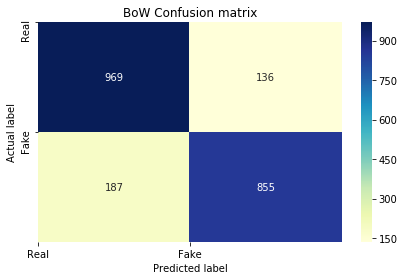

Accuracy: 84.96 %
Precision: 86.28 %
Recall: 82.05 %
Specificity: 87.69 %
Misclassification Rate: 14.29 %


In [547]:
#Section 4.1. Confusion Matrices for initial model comparison

# Create a confusion matrix of Best Performing BoW and TF-IDF Models i.e.those fit to raw headlines
cnf_matrix_bow = metrics.confusion_matrix(y_val, vpredicted_bow_raw)
cnf_matrix_idf = metrics.confusion_matrix(y_val, vpredicted_idf_raw)

# name  of classes
class_names=['Real','Fake'] 
# Set fig and axes 
fig, ax = plt.subplots()
# Create heatmap
%matplotlib inline
sns.heatmap(pd.DataFrame(cnf_matrix_bow), annot=True, cmap="YlGnBu" ,fmt='g')
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
#plt.tight_layout()
plt.title('BoW Naive Bayes Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Real', 'Fake'])   
ax.yaxis.set_ticklabels(['Fake', 'Real'])
plt.ylim([2, 0])
plt.tight_layout()
plt.show()

cnf_matrix_bow = np.array(cnf_matrix_bow).tolist()
tn_fp, fn_tp = cnf_matrix_bow
tn, fp = tn_fp
fn, tp = fn_tp
print("Accuracy:",round(metrics.accuracy_score(y_val, vpredicted_bow_raw)*100, 2),'%')
print("Precision:",round(metrics.precision_score(y_val, vpredicted_bow_raw)*100, 2), '%')
print("Recall:",round(metrics.recall_score(y_val, vpredicted_bow_raw)*100, 2), '%')
print("Specificity:", round((tn/(tn+fp))*100, 2), '%')
print("Misclassification Rate:", round((fp+fn)/(tn+fp+fn+tn)*100, 2), '%')

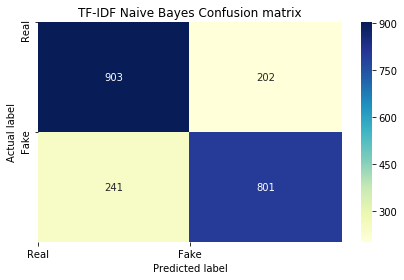

Accuracy: 83.0 %
Precision: 87.49 %
Recall: 75.82 %
Specificity: 81.72 %
Misclassification Rate: 19.7 %


In [548]:
# name  of classes
class_names=['Real','Fake'] 
# Set fig and axes 
fig, ax = plt.subplots()
# Create heatmap
%matplotlib inline
sns.heatmap(pd.DataFrame(cnf_matrix_idf), annot=True, cmap="YlGnBu" ,fmt='g')
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.title('TF-IDF Naive Bayes Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Real', 'Fake'])   
ax.yaxis.set_ticklabels(['Fake', 'Real'])
plt.ylim([2, 0])
plt.tight_layout()
plt.show()

cnf_matrix_idf = np.array(cnf_matrix_idf).tolist()
tn_fp, fn_tp = cnf_matrix_idf
tn, fp = tn_fp
fn, tp = fn_tp
print("Accuracy:",round(metrics.accuracy_score(y_val, vpredicted_idf_raw)*100, 2),'%')
print("Precision:",round(metrics.precision_score(y_val, vpredicted_idf_raw)*100, 2), '%')
print("Recall:",round(metrics.recall_score(y_val, vpredicted_idf_raw)*100, 2), '%')
print("Specificity:", round((tn/(tn+fp))*100, 2), '%')
print("Misclassification Rate:", round((fp+fn)/(tn+fp+fn+tn)*100, 2), '%')

In [563]:
#Raw
count_vec = CountVectorizer(ngram_range = (1,1), stop_words=None) 
Xs_bow_raw = count_vec.fit_transform(X_train)
X_val_raw = count_vec.transform(X_val)
clf_bow = MultinomialNB().fit(Xs_bow_raw, y_train)
vpredicted_bow_raw= clf_bow.predict(X_val_raw)
tpredicted_bow_raw= clf_bow.predict(Xs_bow_raw)
print("BoW MultinomialNB Validation Accuracy Raw Data:",metrics.accuracy_score(y_val, vpredicted_bow_raw)) 
print("BoW MultinomialNB Training Accuracy Raw Data:",metrics.accuracy_score(y_train, tpredicted_bow_raw)) 

BoW MultinomialNB Validation Accuracy Raw Data: 0.8495575221238938
BoW MultinomialNB Training Accuracy Raw Data: 0.9314557879478153


Best score: 0.8420998136260095
Train score 0.9983951128598053
Test score 0.8532836516068933


{'cvec__ngram_range': (1, 3), 'nb__alpha': 1}

In [ ]:
#Section 4.2.

In [593]:
#Model 1 Used in report, report test score/mention over-fitting
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'cvec__ngram_range': [(1,1)],
               'lr__C': [0.01, .1,1,2,5],
               'lr__penalty': ['l1', 'l2']}

gs_lrcv = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs_lrcv.fit(X_train, y_train);

#The actual performance of the model during cross-validation when fit with the hyper-paramters

print("Best score:", gs_lrcv.best_score_)
print("Train score", gs_lrcv.score(X_train, y_train))
print("Test score", gs_lrcv.score(X_test, y_test))

#Print out the actual parameter settings that were found to be optimal
gs_lrcv.best_params_



Best score: 0.8319010147028371
Train score 0.9646924829157175
Test score 0.8385744234800838


{'cvec__ngram_range': (1, 1), 'lr__C': 1, 'lr__penalty': 'l2'}

In [ ]:
gs_lrcv.cv_results_

In [612]:
#Model 2: CountVectorizer (BoW) combined with Multinomial Naive Bayes
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'cvec__ngram_range': [(1,1)],
               'nb__alpha': [.09,.18,.36,.54,.72,.81,1,1.1,1.25,1.5,2,3,5]}

gs_mnb = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs_mnb.fit(X_train, y_train)

#The actual performance of the model during cross-validation when fit with the hyper-paramters
print("Best score:", gs_mnb.best_score_)
print("Train score", gs_mnb.score(X_train, y_train))
print("Test score", gs_mnb.score(X_val, y_val))

#Print out the actual parameter settings that were found to be optimal

gs_mnb.best_params_




Best score: 0.836612135017602
Train score 0.9142679643818596
Test score 0.8467629250116442


{'cvec__ngram_range': (1, 1), 'nb__alpha': 3}

In [ ]:
gs_mnb.cv_results_

In [620]:
#Model 3 Used in report
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98, 1.0],
               'tvect__min_df': [.001, .01, 2],
               'tvect__ngram_range': [(1,1)],
               'lr__C': [.1,1,2],
               'lr__penalty': ['l1', 'l2']}

gs_idf_lr = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs_idf_lr.fit(X_train, y_train);
print("Best score:", gs_idf_lr.best_score_)
print("Train score", gs_idf_lr.score(X_train, y_train))
print("Test score", gs_idf_lr.score(X_test, y_test))

gs_idf_lr.best_params_




Best score: 0.8326775729964796
Train score 0.9273141437150548
Test score 0.8429070580013976


{'lr__C': 2,
 'lr__penalty': 'l2',
 'tvect__max_df': 0.75,
 'tvect__min_df': 2,
 'tvect__ngram_range': (1, 1)}

In [ ]:
gs_idf_lr.cv_results_


In [622]:
#M4 Used in report, report test score/mention over-fitting
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98, 1.0],
               'tvect__min_df': [.001, .01, 2],
               'tvect__ngram_range': [(1,1)],
                'nb__alpha': [.36,.54,.72,.81,1,1.1,1.25,1.5,2]}
#.09,.18,3,5
gs_idf_mnb = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs_idf_mnb.fit(X_train, y_train);
print("Best score:", gs_idf_mnb.best_score_)
print("Train score", gs_idf_mnb.score(X_train, y_train))
print("Test score", gs_idf_mnb.score(X_test, y_test))

gs_idf_mnb.best_params_




Best score: 0.8222199213087595
Train score 0.9046904120936011
Test score 0.8352201257861636


{'nb__alpha': 1.5,
 'tvect__max_df': 0.75,
 'tvect__min_df': 2,
 'tvect__ngram_range': (1, 1)}

#Summaries of the performance of the parameters of the optimised models and their performance #on the test set
cv_lr
Test score 0.8385
{'cvec__ngram_range': (1, 1), 'lr__C': 1, 'lr__penalty': 'l2'}

cv_mnb
Test score 0.8467
{'cvec__ngram_range': (1, 1), 'nb__alpha': 3}

tf-lr
Test score 0.8429
{'lr__C': 2,
 'lr__penalty': 'l2',
 'tvect__max_df': 0.75,
 'tvect__min_df': 2,
 'tvect__ngram_range': (1, 1)}
TF_MNB
Test score: 0.8352
{'nb__alpha': 1.5,
 'tvect__max_df': 0.75,
 'tvect__min_df': 2,
 'tvect__ngram_range': (1, 1)}

In [635]:
#Section 4.3 Hyper-Parameter Optimised Models

#CV_MNB
count_vec = CountVectorizer(ngram_range = (1,1)) 
Xs_bow_raw = count_vec.fit_transform(X_train)
X_val_raw = count_vec.transform(X_val) 
clf_bow = MultinomialNB(alpha=3).fit(Xs_bow_raw, y_train)
vpredicted_bow_raw= clf_bow.predict(X_val_raw)
tpredicted_bow_raw= clf_bow.predict(Xs_bow_raw)
# big no-no! Xs_test = count_vec.transform(X_test)
print("Optimised BoW MultinomialNB Validation Accuracy Raw Data:",metrics.accuracy_score(y_val, vpredicted_bow_raw)) 
print("Optimised BoW MultinomialNB Training Accuracy Raw Data:",metrics.accuracy_score(y_train, tpredicted_bow_raw)) 

#TF-MNB
idf_vec = TfidfVectorizer(sublinear_tf=True, max_df=0.75,min_df=2) 
Xs_idf_raw = idf_vec.fit_transform(X_train)
X_val_raw = idf_vec.transform(X_val) 
clf_idf = MultinomialNB(alpha=1.5).fit(Xs_idf_raw, y_train)
vpredicted_idf_raw= clf_idf.predict(X_val_raw)
tpredicted_idf_raw= clf_idf.predict(Xs_idf_raw)
# big no-no! Xs_test = count_vec.transform(X_test)
print("Optimised TF-IDF MultinomialNB Validation Accuracy Raw Data:",metrics.accuracy_score(y_val, vpredicted_idf_raw)) 
print("Optimised TF-IDF MultinomialNB Training Accuracy Raw Data:",metrics.accuracy_score(y_train, tpredicted_idf_raw)) 


#TF_LR
lr = LogisticRegression(C = 2.0, penalty= 'l2', solver='liblinear')
idf_vec = TfidfVectorizer(sublinear_tf=True, max_df=0.75, min_df = 2,)  
Xs_idf_raw = idf_vec.fit_transform(X_train)
X_val_raw = idf_vec.transform(X_val) 
clf_lr_bow =lr.fit(Xs_idf_raw,y_train)
vpredicted_bow_raw= clf_lr_bow.predict(X_val_raw)
tpredicted_bow_raw= clf_lr_bow.predict(Xs_idf_raw)
# big no-no! Xs_test = count_vec.transform(X_test)
print("Optimised TF-IDF Log Reg Validation Accuracy Raw Data:",metrics.accuracy_score(y_val, vpredicted_idf_raw)) #combo
print("Optimised TF-IDF Log Reg Training Accuracy Raw Data:",metrics.accuracy_score(y_train, tpredicted_idf_raw)) #combo

#cv_LR
lr = LogisticRegression(C = 1, penalty= 'l2', solver='liblinear')
count_vec = CountVectorizer(ngram_range = (1,1)) 
Xs_bow_raw = count_vec.fit_transform(X_train)
X_val_raw = count_vec.transform(X_val) 
clf_lr_bow =lr.fit(Xs_bow_raw,y_train)
vpredicted_bow_raw= clf_lr_bow.predict(X_val_raw)
tpredicted_bow_raw= clf_lr_bow.predict(Xs_bow_raw)
# big no-no! Xs_test = count_vec.transform(X_test)
print("Optimised BoW Log Reg Validation Accuracy Raw Data:",metrics.accuracy_score(y_val, vpredicted_bow_raw)) #combo
print("Optimised BoW Log Reg Training Accuracy Raw Data:",metrics.accuracy_score(y_train, tpredicted_bow_raw)) #combo


Optimised BoW MultinomialNB Validation Accuracy Raw Data: 0.8467629250116442
Optimised BoW MultinomialNB Training Accuracy Raw Data: 0.9142679643818596
Optimised TF-IDF MultinomialNB Validation Accuracy Raw Data: 0.8258034466697718
Optimised TF-IDF MultinomialNB Training Accuracy Raw Data: 0.9047421826465106
Optimised TF-IDF Log Reg Validation Accuracy Raw Data: 0.8258034466697718
Optimised TF-IDF Log Reg Training Accuracy Raw Data: 0.9047421826465106
Optimised BoW Log Reg Validation Accuracy Raw Data: 0.8332557056357709
Optimised BoW Log Reg Training Accuracy Raw Data: 0.9646924829157175


In [645]:
#CV-MNB ON Test Set

count_vec = CountVectorizer(ngram_range = (1,1)) 
Xs_bow_raw = count_vec.fit_transform(X_train)
Xtst_bow_raw = count_vec.transform(X_test) #Watch out for this one
X_val_raw = count_vec.transform(X_val) 

clf_bow = MultinomialNB(alpha=3).fit(Xs_bow_raw, y_train)
vpredicted_bow_raw= clf_bow.predict(X_val_raw)
tstpredicted_bow_raw= clf_bow.predict(Xtst_bow_raw)
print("Optimised BoW MultinomialNB Test Accuracy Raw Data:",metrics.accuracy_score(y_test, tstpredicted_bow_raw)) 
print("Optimised BoW MultinomialNB Validation Accuracy Raw Data:",metrics.accuracy_score(y_val, vpredicted_bow_raw)) 
 


Optimised BoW MultinomialNB Test Accuracy Raw Data: 0.8487770789657582
Optimised BoW MultinomialNB Validation Accuracy Raw Data: 0.8467629250116442


In [868]:
#Saving model to disk
import pickle
filename = 'finalized_model.sav'
pickle.dump(clf_bow, open(filename, 'wb'))
  
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))


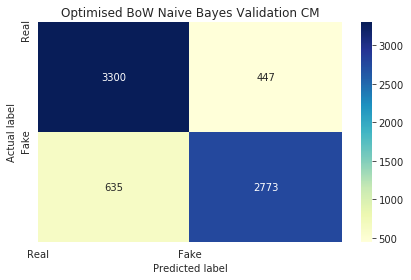

Test Accuracy: 84.88 %
Test Precision: 86.12 %
Test Recall: 81.37 %
Test Specificity: 88.07 %
Test Misclassification Rate: 14.08 %
Val Accuracy: 84.68 %
Val Precision: 86.12 %
Val Recall: 81.57 %
Val Specificity: 87.6 %
Val Misclassification Rate: 14.53 %


In [755]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

##Two different packages were used to generate Confusion Matrices. The code and output for base
#sklearn's confusion matrix is displayed below but scikitplot's version in the next code block were used for the report
cnf_matrix_bow_tst = np.array(cnf_matrix_bow_tst).tolist()
tn_fp, fn_tp = cnf_matrix_bow_tst
tn, fp = tn_fp
fn, tp = fn_tp

print("Test Accuracy:",round(metrics.accuracy_score(y_test, tstpredicted_bow_raw)*100, 2),'%')
print("Test Precision:",round(metrics.precision_score(y_test, tstpredicted_bow_raw)*100, 2), '%')
print("Test Recall:",round(metrics.recall_score(y_test, tstpredicted_bow_raw)*100, 2), '%')
print("Test Specificity:", round((tn/(tn+fp))*100, 2), '%')
print("Test Misclassification Rate:", round((fp+fn)/(tn+fp+fn+tn)*100, 2), '%')
tn_fp, fn_tp = cnf_matrix_val
tn, fp = tn_fp
fn, tp = fn_tp

print("Val Accuracy:",round(metrics.accuracy_score(y_val, vpredicted_bow_raw)*100, 2),'%')
print("Val Precision:",round(metrics.precision_score(y_val, vpredicted_bow_raw)*100, 2), '%')
print("Val Recall:",round(metrics.recall_score(y_val, vpredicted_bow_raw)*100, 2), '%')
print("Val Specificity:", round((tn/(tn+fp))*100, 2), '%')
print("Val Misclassification Rate:", round((fp+fn)/(tn+fp+fn+tn)*100, 2), '%')

In [861]:
cnf_matrix_bow_tst = np.array(cnf_matrix_bow_tst).tolist()
tn_fp, fn_tp = cnf_matrix_bow_tst
tn, fp = tn_fp
fn, tp = fn_tp

print("Test Accuracy:",round(metrics.accuracy_score(y_test, tstpredicted_bow_raw)*100, 2),'%')
print("Test Precision:",round(metrics.precision_score(y_test, tstpredicted_bow_raw)*100, 2), '%')
print("Test Recall:",round(metrics.recall_score(y_test, tstpredicted_bow_raw)*100, 2), '%')
print("Test Specificity:", round((tn/(tn+fp))*100, 2), '%')
print("Test Misclassification Rate:", round((fp+fn)/(tn+fp+fn+tn)*100, 2), '%')
tn_fp, fn_tp = cnf_matrix_val
tn, fp = tn_fp
fn, tp = fn_tp

print("Val Accuracy:",round(metrics.accuracy_score(y_val, vpredicted_bow_raw)*100, 2),'%')
print("Val Precision:",round(metrics.precision_score(y_val, vpredicted_bow_raw)*100, 2), '%')
print("Val Recall:",round(metrics.recall_score(y_val, vpredicted_bow_raw)*100, 2), '%')
print("Val Specificity:", round((tn/(tn+fp))*100, 2), '%')
print("Val Misclassification Rate:", round((fp+fn)/(tn+fp+fn+tn)*100, 2), '%')

Test Accuracy: 84.88 %
Test Precision: 86.12 %
Test Recall: 81.37 %
Test Specificity: 88.07 %
Test Misclassification Rate: 14.08 %
Val Accuracy: 50.26 %
Val Precision: 47.72 %
Val Recall: 46.04 %
Val Specificity: 87.6 %
Val Misclassification Rate: 14.53 %


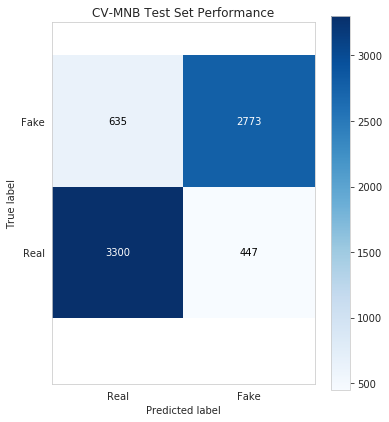

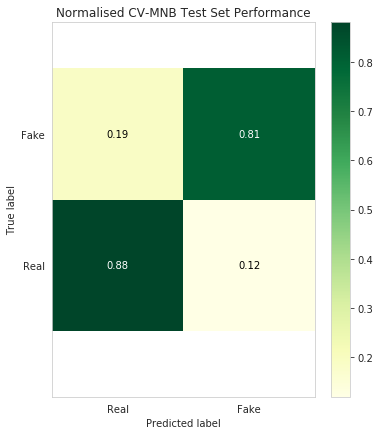

In [851]:
# Scikitplot Confusion Matrices
#Figure 6
skplt.metrics.plot_confusion_matrix(y_test, tstpredicted_bow_raw, labels=None, true_labels=None, pred_labels=None, title='CV-MNB Test Set Performance', normalize=False, hide_zeros=False, hide_counts=False, x_tick_rotation=0, ax=None, figsize=(5.5,5.5), cmap='Blues', title_fontsize='large', text_fontsize='medium')
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.tight_layout()
plt.ylim([-1, 1.75])
#plt.show()
skplt.metrics.plot_confusion_matrix(y_test, tstpredicted_bow_raw, labels=None, true_labels=None, pred_labels=None, title='Normalised CV-MNB Test Set Performance', normalize=True, hide_zeros=False, hide_counts=False, x_tick_rotation=0, ax=None, figsize=(5.5,5.5), cmap='YlGn', title_fontsize='large', text_fontsize='medium')
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.tight_layout()
plt.ylim([-1, 1.85])
plt.show()

AUC: 0.9252


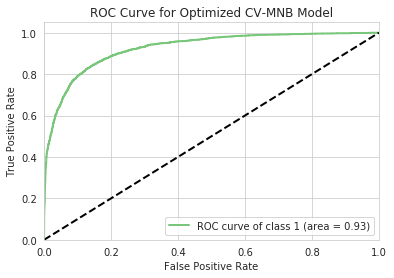

In [854]:
#Section 5.3 ROC Curve
#Note, two packages were also used to generate ROC curves. Scikitplot was deemed more visually 
#clear and used in the report but suffered from limited potential for customisation e.g. plotting ROC curves for 
#multiple models simultaneously

import scikitplot as skplt
import matplotlib.pyplot as plt

probs = clf_bow.predict_proba(Xtst_bow_raw)
probs.shape
#The ground truth labels (y_test) and probabilities (probs) for each prediction 
#Figure 7
skplt.metrics.plot_roc(y_test, probs,title='ROC Curve for Optimized CV-MNB Model',cmap = 'YlGn', plot_micro=False, classes_to_plot = [1],plot_macro=False)
auc = roc_auc_score(y_test, probs[:,1])
print('AUC: %.4f' % auc)
plt.show()

Logistic: ROC AUC=0.925


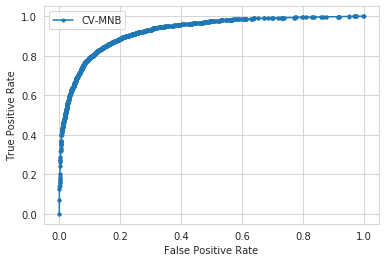

In [744]:
# ROC curve and auc. Not used explicitly in report
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# predict probabilities
#lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
#lr_probs = lr_probs[:, 1]
# calculate scores
#ns_auc = roc_auc_score(testy, ns_probs)
cv_auc = roc_auc_score(y_test, probs[:,1])

print('Logistic: ROC AUC=%.3f' % (cv_auc))
# calculate roc curves
auc = roc_auc_score(y_test, probs[:,1])

fpr, tpr, thresholds = roc_curve(y_test, probs[:,1]) #,pos_label=2


# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.', label='CV-MNB')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

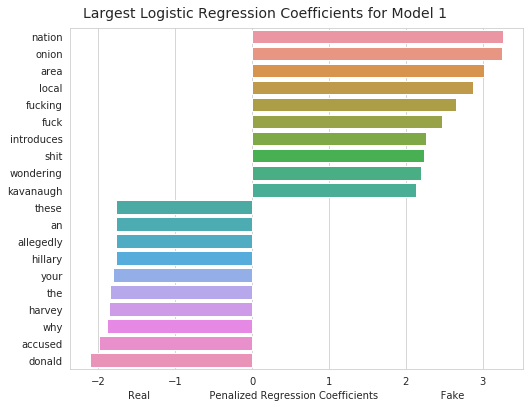

In [860]:
#References
#Citiation http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
#https://github.com/jasminevasandani/NLP_Classification_Model_FakeNews/blob/master/FakeNews_NLP_Classification_Modeling.ipynb

#Section 6.1 Supplementary Graph
#The BoW Logistic Regression (Model 1) above was used to investigate which words were
#particularly powereful in resolving real & fake nws.
lr = LogisticRegression(C = 1.0, solver='liblinear')

# Fit the classifier
Xs_bow_raw = count_vec.fit_transform(X_train)
X_val_raw = count_vec.transform(X_val) 
clf_lr_bow =lr.fit(Xs_bow_raw,y_train)

# Create the predictions for Y training data
vpredicted_bow_raw_lr = lr.predict(X_val_raw)

print(lr.score(X_val_raw, y_val))
# Create list of logistic regression coefficients 
lr_coef = np.array(lr.coef_).tolist() #these are accessed from the lr object which is a fit logistic regression model
lr_coef = lr_coef[0]

# create dataframe from coef
lr_coef = pd.DataFrame(np.round_(lr_coef, decimals=3), 
count_vec.get_feature_names(), columns = ["penalized_regression_coefficients"])

# sort the values from high to low
lr_coef = lr_coef.sort_values(by = 'penalized_regression_coefficients', 
ascending = False)
 
# best and worst performing dataframes
df_head = lr_coef.head(10)
df_tail = lr_coef.tail(10)
df_merged = pd.concat([df_head, df_tail], axis=0)

# plot the sorted dataframe
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
fig.suptitle('Largest Logistic Regression Coefficients for Model 1', size=14)
ax = sns.barplot(x = 'penalized_regression_coefficients', y= df_merged.index, 
data=df_merged)
ax.set(xlabel='Real                   Penalized Regression Coefficients                    Fake')
plt.tight_layout(pad=3, w_pad=0, h_pad=0);
